In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.sparse import coo_matrix
import dask.array as da
from dask.diagnostics import ProgressBar

**Update: This kind of works now. But the performance is worse than Numba.**

# Preparation

Just copy the code from [sparse_dot_benchmark.ipynb](./sparse_dot_benchmark.ipynb).

In [2]:
ds = xr.open_dataset("weights.nc")
n_s = ds.dims['n_s']
col = ds['col'].values - 1
row = ds['row'].values - 1
S = ds['S'].values
A = coo_matrix((S, (row, col))) 

In [3]:
data = np.random.rand(500, A.shape[1])
data.shape

(500, 240000)

In [4]:
# reference result and baseline performance
%time out_scipy = A.dot(data.T).T
out_scipy.shape

CPU times: user 475 ms, sys: 170 ms, total: 645 ms
Wall time: 656 ms


(500, 120000)

# apply_ufunc on numpy array

In [5]:
def apply_A(data):
    # use global A here!
    return A.dot(data.T).T

Has the same performance as before.

In [6]:
%time xr.apply_ufunc(apply_A, data)

CPU times: user 486 ms, sys: 179 ms, total: 664 ms
Wall time: 676 ms


array([[ 0.18415503,  0.30827588,  0.36414446, ...,  0.71783924,
         0.388926  ,  0.4258764 ],
       [ 0.38458325,  0.7984833 ,  0.64423849, ...,  0.32378865,
         0.19628272,  0.32222136],
       [ 0.2824686 ,  0.38493851,  0.40749147, ...,  0.3225105 ,
         0.25545861,  0.71379326],
       ..., 
       [ 0.35136497,  0.38836416,  0.36229975, ...,  0.89467049,
         0.50342856,  0.29044241],
       [ 0.515627  ,  0.39534258,  0.20649153, ...,  0.19967517,
         0.46541354,  0.40270855],
       [ 0.27312149,  0.63370024,  0.3081374 , ...,  0.67607686,
         0.44878322,  0.39344377]])

# apply_ufunc on xarray DataArray

In [7]:
dr = xr.DataArray(data, 
                  dims=['extra_dims', 'grid_dims'],
                  coords=[np.arange(500), np.arange(240000)],
                  name='data'
                 )
dr

<xarray.DataArray 'data' (extra_dims: 500, grid_dims: 240000)>
array([[ 0.003899,  0.38041 ,  0.225732, ...,  0.201686,  0.743291,  0.321241],
       [ 0.218596,  0.851019,  0.820948, ...,  0.021793,  0.642471,  0.249023],
       [ 0.305715,  0.143063,  0.363874, ...,  0.06946 ,  0.667694,  0.699839],
       ..., 
       [ 0.303445,  0.570533,  0.320477, ...,  0.555266,  0.263653,  0.29935 ],
       [ 0.388431,  0.969054,  0.157855, ...,  0.640531,  0.199568,  0.411892],
       [ 0.122485,  0.287483,  0.735536, ...,  0.477552,  0.057254,  0.410433]])
Coordinates:
  * extra_dims  (extra_dims) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * grid_dims   (grid_dims) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...

Has the same performance as before.

In [8]:
%time dr_out = xr.apply_ufunc(apply_A, dr)

CPU times: user 516 ms, sys: 190 ms, total: 706 ms
Wall time: 727 ms


In [9]:
# result is correct
np.array_equal(dr_out.data, out_scipy)

True

# Use dask array

In [10]:
data_dask = da.from_array(data, chunks=(100, 240000))
data_dask

dask.array<array, shape=(500, 240000), dtype=float64, chunksize=(100, 240000)>

**Horribly slow...**

In [11]:
%time out_dask = apply_A(data_dask)
out_dask.shape

CPU times: user 4.03 s, sys: 951 ms, total: 4.98 s
Wall time: 5.05 s


(500, 120000)

In [12]:
# result is correct
np.array_equal(out_dask, out_scipy)

True

# apply_ufunc on dask array, serial

In [13]:
dr_dask = xr.DataArray(data_dask, 
                       dims=['extra_dims', 'grid_dims'],
                       name='data')
dr_dask

<xarray.DataArray 'data' (extra_dims: 500, grid_dims: 240000)>
dask.array<shape=(500, 240000), dtype=float64, chunksize=(100, 240000)>
Dimensions without coordinates: extra_dims, grid_dims

**As slow as the previous case...**

In [14]:
%time dr_out_dask = xr.apply_ufunc(apply_A, dr_dask, dask='allowed')

CPU times: user 4.13 s, sys: 1.03 s, total: 5.16 s
Wall time: 5.24 s


In [15]:
# result is correct
np.array_equal(dr_out_dask, out_scipy)

True

# apply_ufunc on dask array, parallelized

In [16]:
%%time 
dr_out_pa = xr.apply_ufunc(apply_A, dr_dask, 
                           input_core_dims=[['grid_dims']],
                           output_core_dims=[['out_grid']],
                           output_sizes={'out_grid': 120000},
                           dask='parallelized', 
                           output_dtypes=[float])

CPU times: user 151 ms, sys: 49.7 ms, total: 200 ms
Wall time: 201 ms


In [17]:
dr_out_pa # not computed yet

<xarray.DataArray 'data' (extra_dims: 500, out_grid: 120000)>
dask.array<shape=(500, 120000), dtype=float64, chunksize=(100, 120000)>
Dimensions without coordinates: extra_dims, out_grid

**Much faster than the previous case, but still slower than the pure numpy case.**

In [18]:
%time dr_out_pa.compute()

CPU times: user 1.02 s, sys: 921 ms, total: 1.94 s
Wall time: 1.03 s


<xarray.DataArray 'data' (extra_dims: 500, out_grid: 120000)>
array([[ 0.184155,  0.308276,  0.364144, ...,  0.717839,  0.388926,  0.425876],
       [ 0.384583,  0.798483,  0.644238, ...,  0.323789,  0.196283,  0.322221],
       [ 0.282469,  0.384939,  0.407491, ...,  0.322511,  0.255459,  0.713793],
       ..., 
       [ 0.351365,  0.388364,  0.3623  , ...,  0.89467 ,  0.503429,  0.290442],
       [ 0.515627,  0.395343,  0.206492, ...,  0.199675,  0.465414,  0.402709],
       [ 0.273121,  0.6337  ,  0.308137, ...,  0.676077,  0.448783,  0.393444]])
Dimensions without coordinates: extra_dims, out_grid

In [19]:
# result is correct
np.array_equal(dr_out_pa.data, out_scipy)

True

# Low-level implementation dask delayed

In [20]:
from dask import delayed

Manully break data into 5 chunks

In [21]:
i = 0 
data[100*i:100*(i+1), :].shape # input chunk shape

(100, 240000)

In [22]:
apply_A(data[100*i:100*(i+1), :]).shape # output chunk shape

(100, 120000)

A list of output results from 5 chunks

In [23]:
out_delayed = [delayed(apply_A)(data[100*i:100*(i+1), :]) for i in range(5)]
out_delayed

[Delayed('apply_A-ebb4af45-81bd-42eb-8bfa-14b8479cd116'),
 Delayed('apply_A-75b615d6-1888-44b4-89b3-9a2dff4f70e7'),
 Delayed('apply_A-ae8d279b-3d7d-44ca-beb3-df10903e6e03'),
 Delayed('apply_A-c752d4ce-094a-4465-8062-0a956b0e1b15'),
 Delayed('apply_A-e358ff19-2c08-463b-8e56-27f1dbfa401c')]

Convert to dask arrays:

In [24]:
dask_subarrays = [da.from_delayed(d, (100, 120000), float) for d in out_delayed]
dask_subarrays

[dask.array<from-value, shape=(100, 120000), dtype=float64, chunksize=(100, 120000)>,
 dask.array<from-value, shape=(100, 120000), dtype=float64, chunksize=(100, 120000)>,
 dask.array<from-value, shape=(100, 120000), dtype=float64, chunksize=(100, 120000)>,
 dask.array<from-value, shape=(100, 120000), dtype=float64, chunksize=(100, 120000)>,
 dask.array<from-value, shape=(100, 120000), dtype=float64, chunksize=(100, 120000)>]

Merge into a single dask array:

In [25]:
dask_merge = da.concatenate(dask_subarrays, axis=0)
dask_merge

dask.array<concatenate, shape=(500, 120000), dtype=float64, chunksize=(100, 120000)>

In [26]:
np.array_equal(dask_merge, out_scipy) # result is correct

True

Parallelization does give some speed-up. But the serial version is slower than pure numpy version, and the parallel efficiency is worse than Numba.

In [27]:
%timeit dask_merge.compute(num_workers=1)
%timeit dask_merge.compute(num_workers=2)
%timeit dask_merge.compute(num_workers=4)

779 ms ± 76.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
554 ms ± 8.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
580 ms ± 43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


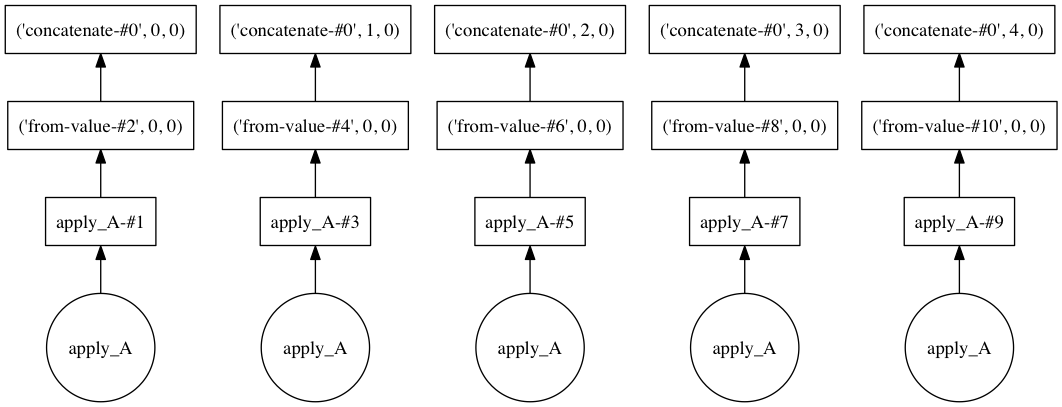

In [28]:
dask_merge.visualize()